Import Libraries

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


Load Dataset

In [138]:
df = pd.read_csv('generated_dataset.csv')
df.head()


,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202


Binning Target: Leak vs No Leak (Percentile-based)

In [139]:
# percentile = 0.8  # 80th percentile
# threshold = df['CR-corrosion defect'].quantile(percentile)
threshold = 0.25  # threshold for leak detection
df['Leak_Status'] = np.where(df['CR-corrosion defect'] >= threshold, 'Leak', 'No Leak')

df.head()



,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect,Leak_Status
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245,No Leak
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262,No Leak
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305,No Leak
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303,No Leak
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202,No Leak


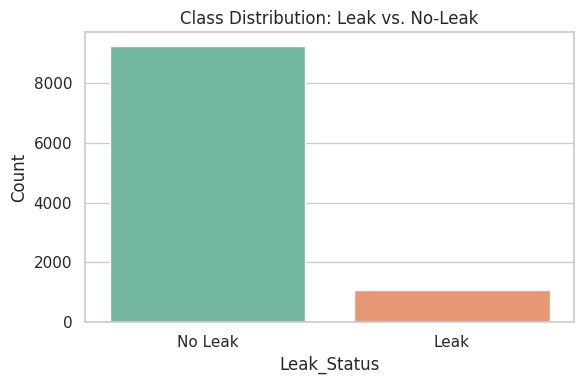

In [140]:

# Visualizing the class distribution

# Assuming your class labels are in the column 'leak_label'
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6,4))

# Countplot of leak classes
sns.countplot(data=df, x='Leak_Status', hue='Leak_Status', palette='Set2', legend=False)

# Optional: Add titles and axis labels
plt.title('Class Distribution: Leak vs. No-Leak')
plt.xlabel('Leak_Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Encode Target Labels

In [141]:
le = LabelEncoder()
y = le.fit_transform(df['Leak_Status'])


Train-Test Split

In [142]:
X = df.drop(['CR-corrosion defect', 'Leak_Status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


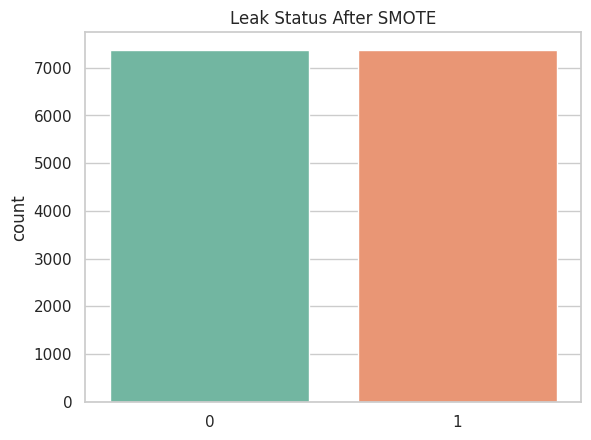

In [143]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

sns.countplot(x=y_train, hue=y_train, palette='Set2', legend=False)
plt.title('Leak Status After SMOTE')
plt.show()

Cross-Validation

Roc_Auc Scores: [0.98576915 0.9788139  0.98418661 0.98180806 0.98198376]
Mean Roc_Auc Score: 0.9825122981161154


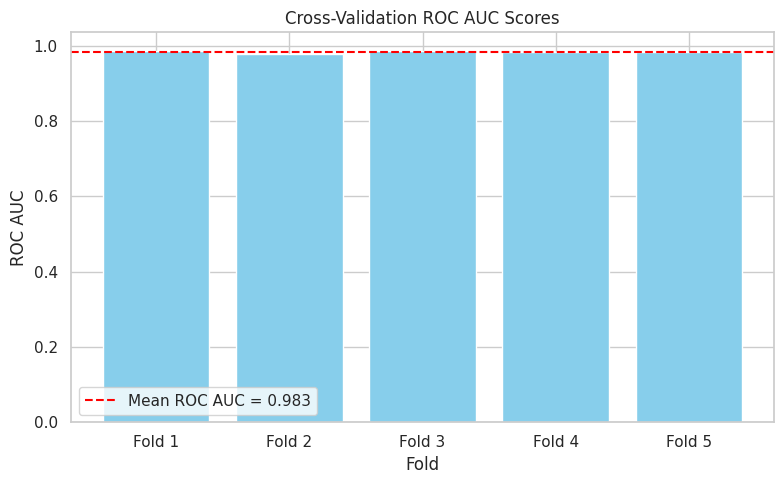

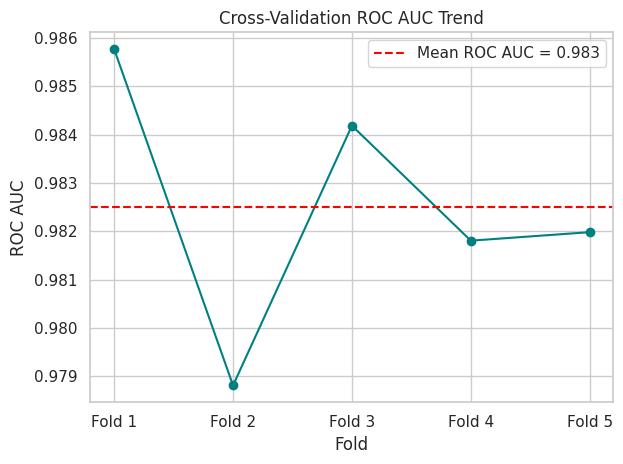

In [144]:
# Validation set

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
print("Roc_Auc Scores:", cv_scores)
print("Mean Roc_Auc Score:", np.mean(cv_scores))

# Plotting Bar Chart of ROC AUC Across Folds
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue')
plt.axhline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean ROC AUC = {np.mean(cv_scores):.3f}')
plt.xticks(range(1, len(cv_scores)+1), [f'Fold {i}' for i in range(1, len(cv_scores)+1)])
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('Cross-Validation ROC AUC Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Line Plot to Visualize Score Trends
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', linestyle='-', color='teal')
plt.axhline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean ROC AUC = {np.mean(cv_scores):.3f}')
plt.xticks(range(1, len(cv_scores)+1), [f'Fold {i}' for i in range(1, len(cv_scores)+1)])
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('Cross-Validation ROC AUC Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Train, Predict & Evaluate

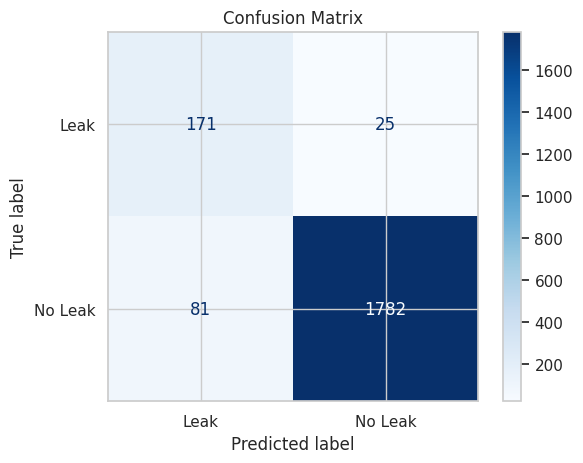

,precision,recall,f1-score,support
Leak,0.68,0.87,0.76,196.00
No Leak,0.99,0.96,0.97,1863.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.83,0.91,0.87,2059.00
weighted avg,0.96,0.95,0.95,2059.00


In [145]:
from sklearn.metrics import ConfusionMatrixDisplay


# Train model
model.fit(X_train, y_train)

y_scores = model.decision_function(X_test)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)



Visualize ROC Curves

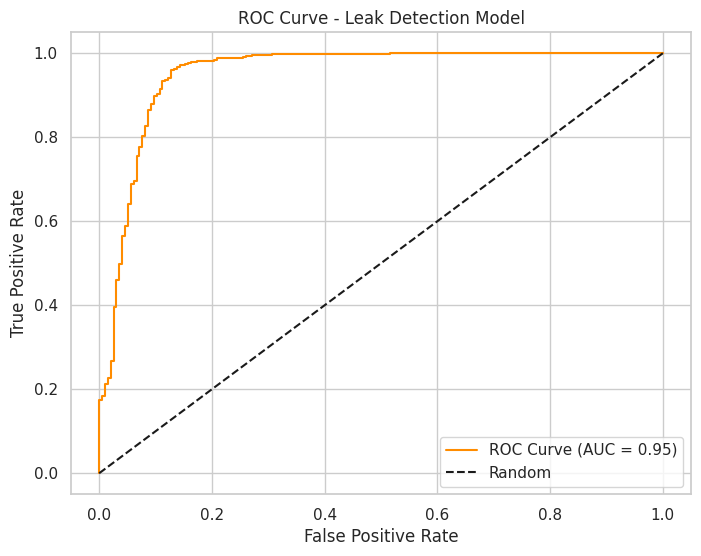

In [146]:

# 🧪 ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Leak Detection Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





Visualize Feature Importance

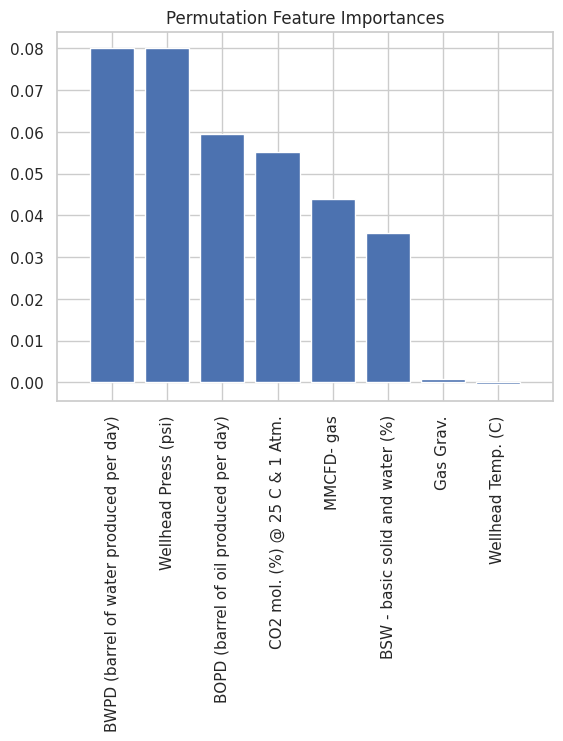

In [147]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.title("Permutation Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Save model

In [148]:
# Save model with pickle
import pickle

with open('svm_leak_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Example usecase

In [149]:
# Load model with pickle
with open('svm_leak_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Example feature values
example = pd.DataFrame([{
    'Wellhead Temp. (C)': 85,
    'Wellhead Press (psi)': 2500,
    'MMCFD- gas': 12,
    'BOPD (barrel of oil produced per day)': 500,
    'BWPD (barrel of water produced per day)': 200,
    'BSW - basic solid and water (%)': 5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 2.5,
    'Gas Grav.': 0.7
}])

# Use same scaler as during training
example_scaled = scaler.transform(example)

# Predict
pred = model.predict(example_scaled)
pred_label = le.inverse_transform(pred)
print("Predicted Leak Status:", pred_label[0])

# Get probability scores for each class
proba = model.predict_proba(example_scaled)

# Probability for the predicted class:
print(f"Probability: {proba[0][pred[0]] * 100:.2f}%")

Predicted Leak Status: No Leak
Probability: 99.06%
